### **Train a deep neural network model in PyTorch for multi-label text classification** 

In [14]:
import pandas as pd
tweet = pd.read_csv('mLabel_tweets.csv', usecols=[1,2], names=['tweet', 'labels'],skiprows=1 )

### **Preprocess text before loding to model**


In [15]:
import re
import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer, PorterStemmer

nltk.download('stopwords')
nltk.download('wordnet')

stopwords = set(stopwords.words('english'))
lematizer = WordNetLemmatizer()

def preprocess_text(text):
    text = text.lower()
    text = re.sub(r"http\S+|www\S+|https\S+", "", text)
    text = re.sub(r"[^a-zA-Z\s]", "", text)
    words = text.split()

    clean_words = [ lematizer.lemmatize(w) for w in words if w not in stopwords ]

    return " ".join(clean_words)

tweet['tweet'] = tweet['tweet'].astype(str).apply(preprocess_text)

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\NCS\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\NCS\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


The history saving thread hit an unexpected error (OperationalError('database or disk is full')).History will not be written to the database.


### **Train Test Split**

In [16]:
from sklearn.model_selection import train_test_split

X = tweet['tweet']
y = tweet['labels']

X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42, test_size=0.3)
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((6944,), (2977,), (6944,), (2977,))

### **Multi Label Binarizer**


In [17]:
from sklearn.preprocessing import MultiLabelBinarizer
mlb = MultiLabelBinarizer()

y_train = mlb.fit_transform(y_train)
y_test  = mlb.transform(y_test)

num_classes = len(mlb.classes_)
print("Number of classes:", num_classes)

Number of classes: 21


### **Tokenize**

In [18]:
from nltk.tokenize import word_tokenize

def tokenize_text(docs):
    return [ [w.lower() for w in word_tokenize(text) if w.isalpha()] for text in docs ]

X_train_tokens = tokenize_text(X_train)
X_test_tokens  = tokenize_text(X_test)


### **Word2Vec Embedding**

In [20]:
import gensim.downloader as api
import numpy as np

word2vec_model = api.load('word2vec-google-news-300')
EMB_DIM = word2vec_model.vector_size

def document_vector(tokens):
    tokens = [w for w in tokens if w in word2vec_model]
    if len(tokens) == 0:
        return np.zeros(EMB_DIM)
    return np.mean(word2vec_model[tokens], axis=0)

X_train_vec = np.array([document_vector(t) for t in X_train_tokens], dtype=np.float32)
X_test_vec  = np.array([document_vector(t) for t in X_test_tokens], dtype=np.float32)

### **Creating DataLoaders to feed into MLP**

In [21]:
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, TensorDataset

train_dataset = TensorDataset(torch.tensor(X_train_vec), torch.tensor(y_train, dtype=torch.float32))
test_dataset  = TensorDataset(torch.tensor(X_test_vec), torch.tensor(y_test,  dtype=torch.float32))

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_loader  = DataLoader(test_dataset, batch_size=32, shuffle=False)


### **Text Classifier MLP**

In [22]:
class TextClassifier(nn.Module):
    def __init__(self, in_feature, out_feature):
        super().__init__()
        self.fc1 = nn.Linear(in_feature, 128)
        self.dropout = nn.Dropout(0.3)
        self.fc2 = nn.Linear(128, out_feature)
        self.relu = nn.ReLU()

    def forward(self, x):
        x = self.relu(self.fc1(x))
        x = self.dropout(x)
        return self.fc2(x)

device = "cuda" if torch.cuda.is_available() else "cpu"
print("Using device:", device)

word2vec_model = TextClassifier(EMB_DIM, num_classes).to(device)
loss_fn = nn.BCEWithLogitsLoss()
optimizer = torch.optim.Adam(word2vec_model.parameters(), lr=1e-4)

Using device: cpu


### **Training Loop**

In [23]:
epochs = 50
for epoch in range(epochs):
    total_loss = 0
    correct = 0
    total = 0

    word2vec_model.train()
    for xb, yb in train_loader:
        xb, yb = xb.to(device), yb.to(device)

        optimizer.zero_grad()
        preds = word2vec_model(xb)
        loss = loss_fn(preds, yb)
        loss.backward()
        optimizer.step()

        total_loss += loss.item()

        prob = torch.sigmoid(preds)
        pred_label = (prob > 0.5).float()
        correct += (pred_label == yb).sum().item()
        total += yb.numel()

    acc = correct / total
    loss = total_loss/len(train_loader)
    print(f"Epoch {epoch+1}/{epochs} Train Loss: {loss:.2f} | Train Accuracy: {acc:.4f}")

print("Word2vec Model Training Completed 🎉")

Epoch 1/50 Train Loss: 0.65 | Train Accuracy: 0.6692
Epoch 2/50 Train Loss: 0.57 | Train Accuracy: 0.7170
Epoch 3/50 Train Loss: 0.55 | Train Accuracy: 0.7204
Epoch 4/50 Train Loss: 0.54 | Train Accuracy: 0.7249
Epoch 5/50 Train Loss: 0.53 | Train Accuracy: 0.7331
Epoch 6/50 Train Loss: 0.52 | Train Accuracy: 0.7404
Epoch 7/50 Train Loss: 0.51 | Train Accuracy: 0.7463
Epoch 8/50 Train Loss: 0.50 | Train Accuracy: 0.7509
Epoch 9/50 Train Loss: 0.50 | Train Accuracy: 0.7555
Epoch 10/50 Train Loss: 0.49 | Train Accuracy: 0.7574
Epoch 11/50 Train Loss: 0.49 | Train Accuracy: 0.7606
Epoch 12/50 Train Loss: 0.48 | Train Accuracy: 0.7627
Epoch 13/50 Train Loss: 0.48 | Train Accuracy: 0.7636
Epoch 14/50 Train Loss: 0.48 | Train Accuracy: 0.7654
Epoch 15/50 Train Loss: 0.47 | Train Accuracy: 0.7677
Epoch 16/50 Train Loss: 0.47 | Train Accuracy: 0.7701
Epoch 17/50 Train Loss: 0.47 | Train Accuracy: 0.7715
Epoch 18/50 Train Loss: 0.47 | Train Accuracy: 0.7724
Epoch 19/50 Train Loss: 0.47 | Train 

In [ ]:
import numpy as np
import torch
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import (classification_report, confusion_matrix, f1_score, roc_auc_score, roc_curve, auc)

device = "cuda" if torch.cuda.is_available() else "cpu"

def evaluate_model(model, loader, model_name):
    model.eval()
    all_preds, all_labels, all_probas = [], [], []

    with torch.no_grad():
        for xb, yb in loader:
            xb = xb.to(device)
            out = torch.sigmoid(model(xb))

            prob = out.cpu().numpy()
            preds = (prob > 0.5).astype(int)

            all_probas.extend(prob)
            all_preds.extend(preds)
            all_labels.extend(yb.numpy())

    print(f"\n================= {model_name} =================")
    
    ## Classification Report
    print("\nClassification Report:")
    print(classification_report(all_labels, all_preds, target_names=mlb.classes_))

    ## Micro/Macro F1
    print("Micro F1 Score:", f1_score(all_labels, all_preds, average="micro"))
    print("Macro F1 Score:", f1_score(all_labels, all_preds, average="macro"))

    ## ROC-AUC Scores
    print("\nROC-AUC per class:")
    for i, label in enumerate(mlb.classes_):
        score = roc_auc_score([lbl[i] for lbl in all_labels],
                              [prob[i] for prob in all_probas])
        print(f"{label}: {score:.3f}")

    macro_auc = roc_auc_score(all_labels, all_probas, average="macro")
    micro_auc = roc_auc_score(all_labels, all_probas, average="micro")
    print(f"\nMacro-Average ROC-AUC: {macro_auc:.3f}")
    print(f"Micro-Average ROC-AUC: {micro_auc:.3f}")

    ## Plot ROC Curves
    plt.figure(figsize=(8,6))
    for i, label in enumerate(mlb.classes_):
        fpr, tpr, _ = roc_curve([lbl[i] for lbl in all_labels],
                                [prob[i] for prob in all_probas])
        auc_score = auc(fpr, tpr)
        plt.plot(fpr, tpr, label=f"{label} AUC={auc_score:.3f}")
    
    plt.plot([0,1], [0,1], 'k--')
    plt.title(f"ROC Curve — {model_name}")
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    plt.legend()
    plt.show()

    ## Confusion Matrix per Label
    for i, label in enumerate(mlb.classes_):
        cm = confusion_matrix([lbl[i] for lbl in all_labels],
                              [pred[i] for pred in all_preds])

        plt.figure(figsize=(3,3))
        sns.heatmap(cm, annot=True, fmt="d", cmap="Blues")
        plt.title(f"Confusion Matrix — {model_name}: {label}")
        plt.xlabel("Predicted")
        plt.ylabel("Actual")
        plt.show()



================= Word2Vec Multi-Label DNN =================

Classification Report:


a:\V_ENV\Lib\site-packages\sklearn\metrics\_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])


              precision    recall  f1-score   support

                   0.00      0.00      0.00       601
           -       0.80      0.68      0.73      1121
           a       0.70      0.53      0.60      1032
           c       0.78      0.88      0.83      2062
           d       0.77      0.80      0.78      1778
           e       0.87      0.94      0.90      2362
           f       0.77      0.77      0.77      1572
           g       0.00      0.00      0.00       160
           h       0.76      0.39      0.52       803
           i       0.76      0.85      0.80      1923
           l       0.00      0.00      0.00       191
           m       0.67      0.37      0.47       610
           n       0.72      0.72      0.72      1377
           o       0.68      0.46      0.54       778
           p       0.73      0.40      0.52       648
           r       0.71      0.69      0.70      1422
           s       0.79      0.81      0.80      1857
           t       0.75    

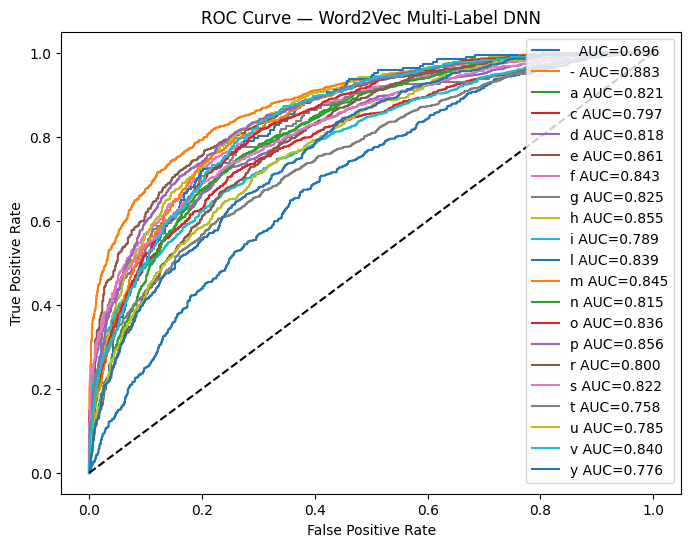

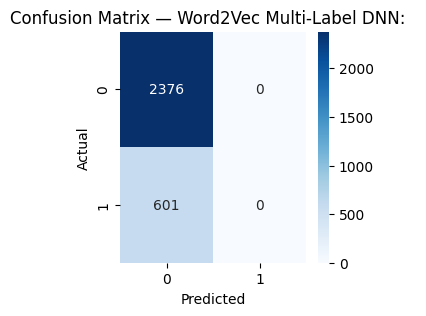

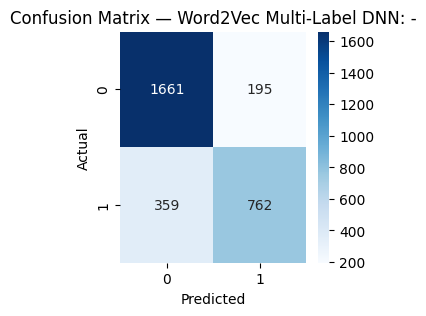

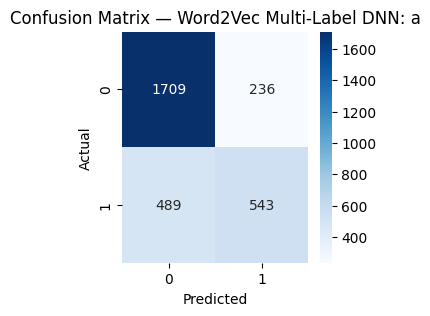

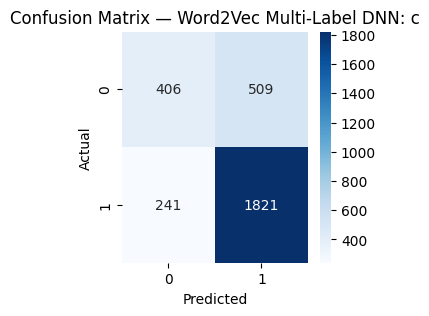

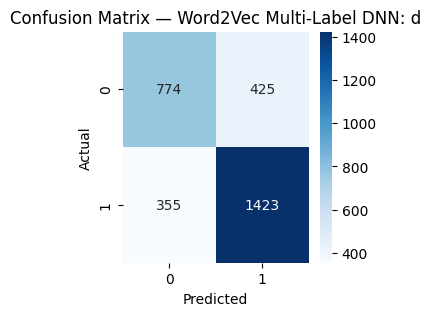

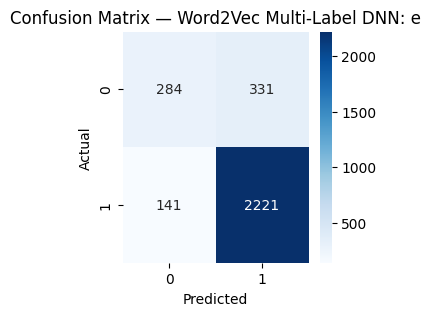

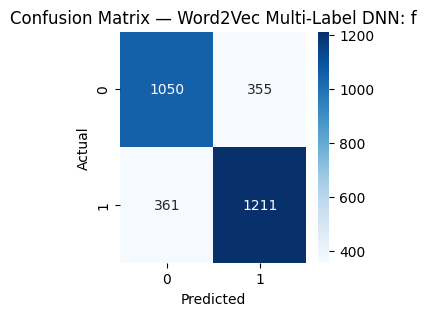

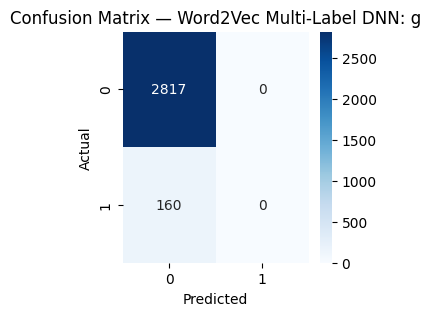

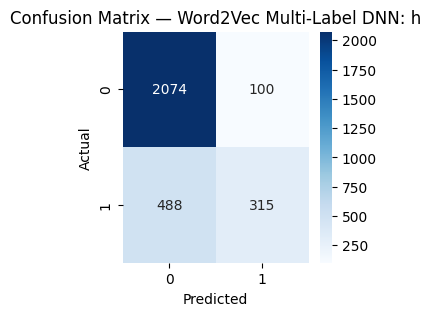

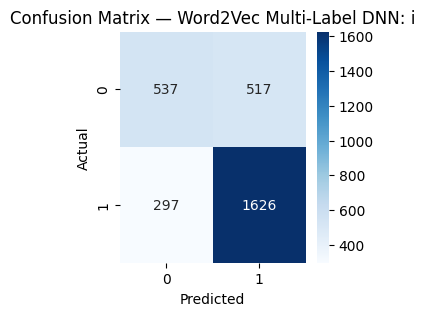

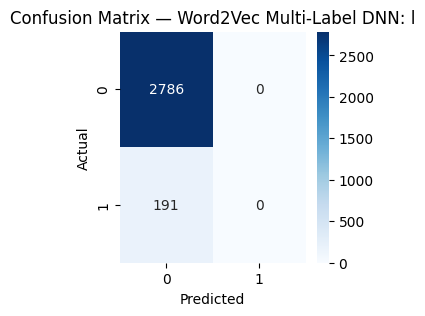

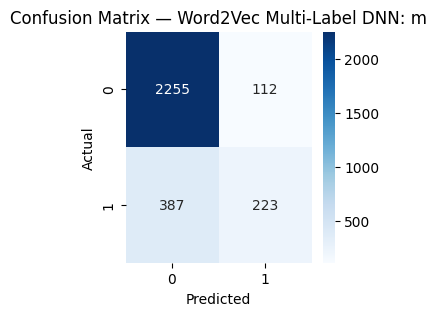

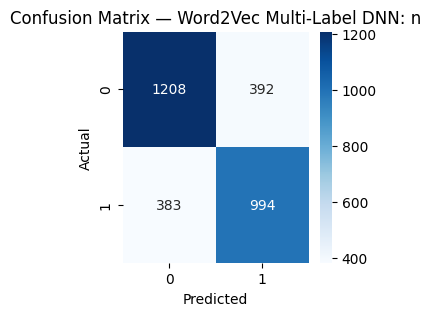

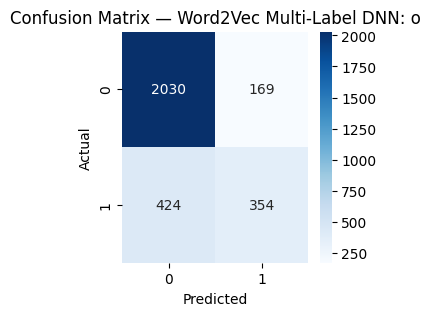

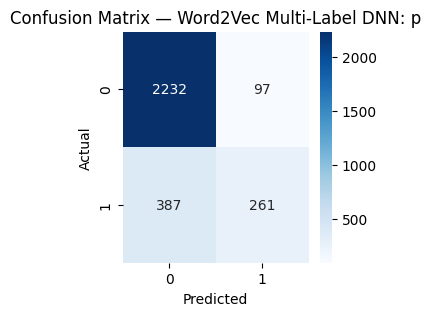

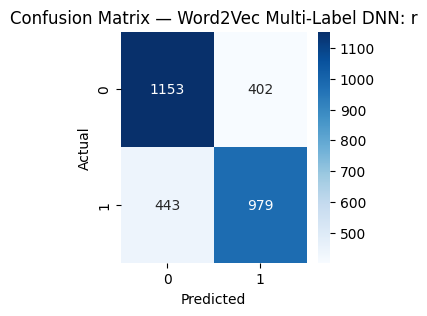

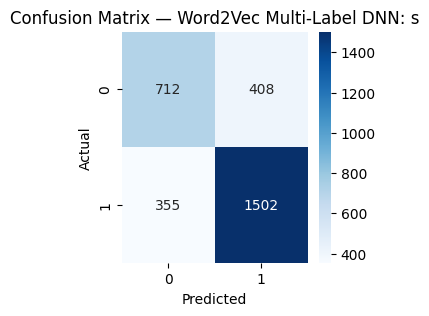

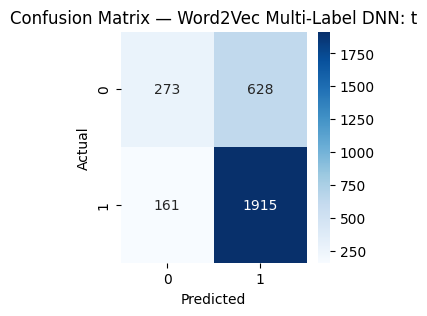

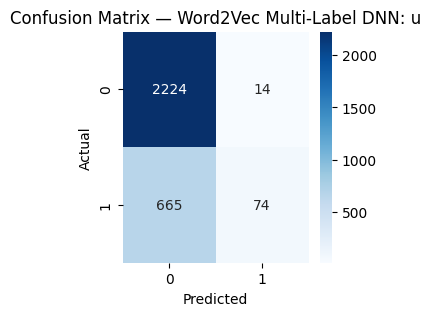

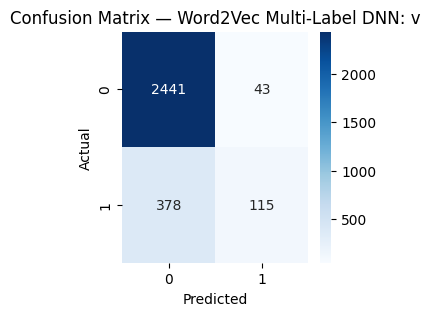

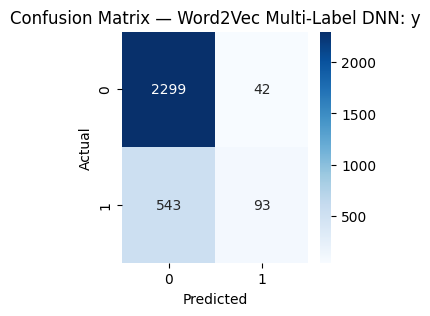

In [26]:
w2v_test_dataset = TensorDataset(
    torch.tensor(X_test_vec), torch.tensor(y_test, dtype=torch.float32)
)
w2v_test_loader = DataLoader(w2v_test_dataset, batch_size=32, shuffle=False)

evaluate_model(word2vec_model, w2v_test_loader, "Word2Vec Multi-Label DNN")
